# Figure. peQTNs and GWAS    

In [1]:
import cPickle
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import tabix
import vcf as pyvcf
import weblogolib as logo

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_peqtns_and_gwas'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [49]:
fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'no_cnv_nmd_vars_gv.tsv')
gv = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'peqtns.tsv')
peqtns = pd.read_table(fn, index_col=0)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'gwas_analysis', 'pe_no_hla_grasp_counts.tsv')
grasp_counts = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'gwas_analysis', 'grasp_results.tsv')
grasp_res = pd.read_table(fn, index_col=0)
#grasp_res['phenotype'] = grasp_res.phenotype.apply(lambda x: x.split(' (')[0])

grasp_counts.index = grasp_res.ix[grasp_counts.index, 'phenotype']
grasp_res.index = grasp_res.phenotype
grasp_res = grasp_res.ix[[x for x in grasp_res.index if 'xpression' not in x]]

## Paper

In [103]:
a = pd.Series(gv['q.value_maurano'].values, index=gv.location)
b = pd.Series(peqtns['q.value_maurano'].values, index=peqtns.location)
a = a.drop(b.index)
ana = a.isnull().sum()
asig = sum(a.dropna() < 0.05)
ansig = a.dropna().shape[0] - asig
bna = b.isnull().sum()
bsig = sum(b.dropna() < 0.05)
bnsig = b.dropna().shape[0] - bsig

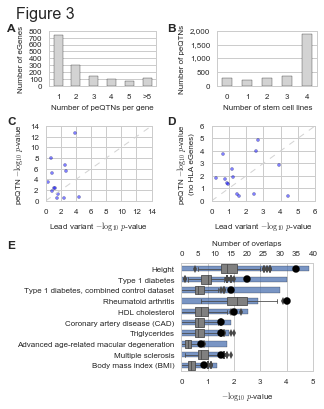

In [146]:
fig = plt.figure(figsize=(4.48, 5.75), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 3',
        size=16, va='top')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.90, 1, 1])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
vc = peqtns.gene_id.value_counts().value_counts().sort_index()
ind = vc[vc.index > 5].index
vc['>5'] = vc[ind].sum()
vc = vc.drop(ind)
vc.plot(kind='bar', ax=ax, color='lightgrey')
plt.ylabel('Number of eGenes', fontsize=8)
plt.xlabel('Number of peQTNs per gene', fontsize=8)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.grid(axis='x')
gs.tight_layout(fig, rect=[0, 0.69, 0.5, 0.95])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
vc = peqtns.drop_duplicates(subset='location').roadmap_dnase_num.value_counts().sort_index()
vc.index = [int(x) for x in vc.index]
vc.plot(kind='bar', ax=ax, color='lightgrey')
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.grid(axis='x')
ax.set_xlabel('Number of stem cell lines', fontsize=8)
ax.set_ylabel('Number of peQTNs', fontsize=8)
ax.yaxis.set_major_formatter(ciepy.comma_format)
gs.tight_layout(fig, rect=[0.5, 0.69, 1, 0.95])

# GWAS scatters
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = grasp_res[(grasp_res.lead_pvalue < 0.05) | (grasp_res.pe_pvalue < 0.05)]
ax.scatter(-np.log10(t.lead_pvalue), -np.log10(t.pe_pvalue), alpha=0.5, s=10)
ax.set_xlabel('Lead variant $-\\log_{10}$ $p$-value', fontsize=8)
ax.set_ylabel('peQTN $-\\log_{10}$ $p$-value', fontsize=8)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.plot([0, max(xmax, ymax)], [0, max(xmax, ymax)], linewidth=1, ls='--', color='lightgrey')
ax.set_xlim(0, max(xmax, ymax))
ax.set_ylim(0, max(xmax, ymax))
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0.41, 0.5, 0.72])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = grasp_res[(grasp_res.lead_pvalue < 0.05) | (grasp_res.pe_no_hla_pvalue < 0.05)]
ax.scatter(-np.log10(t.lead_pvalue), -np.log10(t.pe_no_hla_pvalue), alpha=0.5, s=10)
ax.set_xlabel('Lead variant $-\\log_{10}$ $p$-value', fontsize=8)
ax.set_ylabel('peQTN $-\\log_{10}$ $p$-value\n(no HLA eGenes)', fontsize=8)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.plot([0, max(xmax, ymax)], [0, max(xmax, ymax)], linewidth=1, ls='--', color='lightgrey')
ax.set_xlim(0, max(xmax, ymax))
ax.set_ylim(0, max(xmax, ymax))
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)
gs.tight_layout(fig, rect=[0.5, 0.41, 1, 0.72])

# GWAS enrichment
gs = gridspec.GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])

grasp_res.sort_values(by='pe_no_hla_pvalue', inplace=True)
t = grasp_res[grasp_res.pe_no_hla_pvalue < 0.05]
#t = grasp_res[grasp_res.pe_no_hla_bh_sig]

ymin = 0
ymax= t.shape[0]

ax2.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
h = 0.5
step = abs(ymax - ymin) / t.shape[0]
b = np.arange(ymin, ymax, step) + (step / 2 - h / 2)
ax2.barh(b, -np.log10(grasp_res.ix[t.index, 'pe_no_hla_pvalue']), height=h, 
         alpha=0.75, zorder=4)

ax = ax2.twiny()

ax = sns.boxplot(data=grasp_counts.ix[t.index, grasp_counts.columns[1:]].T, ax=ax, 
                 orient='h', linewidth=0.8)
boxes = ax.artists
for i,box in enumerate(boxes):
    box.set_facecolor('grey')
ax.scatter(grasp_counts.ix[t.index, 'real'], range(t.shape[0]), s=50, 
           color='black', marker='o', zorder=4)

xmin, xmax = ax.get_xlim()
# for i in range(se.shape[0]):
#     ax.text(0.97 * xmax, i, se.values[i], va='center', ha='center')
ax.set_xlabel('Number of overlaps', fontsize=8)
ax.set_xlim(0, xmax)
ax.set_ylabel('')
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)

ymin,ymax = ax.get_ylim()

ax.set_ylim(ymin, ymax)
#ax.set_xlim(0, 50)
# ax2.set_yticklabels(grasp_res.ix[t.index, 'phenotype'], fontsize=8)
# for t in ax.get_xticklabels() + ax.get_yticklabels():
#     t.set_fontsize(8)

ax.grid(axis='x')
ax2.grid(axis='y')
for tick in ax2.get_xticklabels() + ax2.get_yticklabels():
    tick.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0, 1, 0.44])

t = fig.text(0.005, 0.915, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.915, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.69, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.69, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.39, 'E', weight='bold', 
             size=12)

plt.savefig(os.path.join(outdir, 'peqtns_gwas.pdf'))
plt.savefig(os.path.join(outdir, 'peqtns_gwas.png'), dpi=300)

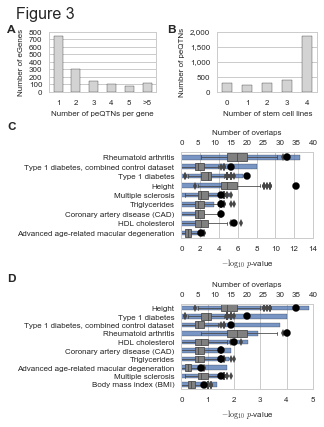

In [156]:
fig = plt.figure(figsize=(4.48, 6), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 3',
        size=16, va='top')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.90, 1, 1])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
vc = peqtns.gene_id.value_counts().value_counts().sort_index()
ind = vc[vc.index > 5].index
vc['>5'] = vc[ind].sum()
vc = vc.drop(ind)
vc.plot(kind='bar', ax=ax, color='lightgrey')
plt.ylabel('Number of eGenes', fontsize=8)
plt.xlabel('Number of peQTNs per gene', fontsize=8)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.grid(axis='x')
gs.tight_layout(fig, rect=[0, 0.69, 0.5, 0.95])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
vc = peqtns.drop_duplicates(subset='location').roadmap_dnase_num.value_counts().sort_index()
vc.index = [int(x) for x in vc.index]
vc.plot(kind='bar', ax=ax, color='lightgrey')
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.grid(axis='x')
ax.set_xlabel('Number of stem cell lines', fontsize=8)
ax.set_ylabel('Number of peQTNs', fontsize=8)
ax.yaxis.set_major_formatter(ciepy.comma_format)
gs.tight_layout(fig, rect=[0.5, 0.69, 1, 0.95])

# GWAS enrichment
gs = gridspec.GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])

grasp_res.sort_values(by='pe_pvalue', inplace=True)
t = grasp_res[grasp_res.pe_pvalue < 0.05]

ymin = 0
ymax= t.shape[0]

ax2.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
h = 0.5
step = abs(ymax - ymin) / t.shape[0]
b = np.arange(ymin, ymax, step) + (step / 2 - h / 2)
ax2.barh(b, -np.log10(grasp_res.ix[t.index, 'pe_pvalue']), height=h, 
         alpha=0.75, zorder=4)

ax = ax2.twiny()

ax = sns.boxplot(data=grasp_counts.ix[t.index, grasp_counts.columns[1:]].T, ax=ax, 
                 orient='h', linewidth=0.8)
boxes = ax.artists
for i,box in enumerate(boxes):
    box.set_facecolor('grey')
ax.scatter(grasp_counts.ix[t.index, 'real'], range(t.shape[0]), s=50, 
           color='black', marker='o', zorder=4)

xmin, xmax = ax.get_xlim()
# for i in range(se.shape[0]):
#     ax.text(0.97 * xmax, i, se.values[i], va='center', ha='center')
ax.set_xlabel('Number of overlaps', fontsize=8)
ax.set_xlim(0, xmax)
ax.set_ylabel('')
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)

ymin,ymax = ax.get_ylim()

ax.set_ylim(ymin, ymax)
#ax.set_xlim(0, 50)
# ax2.set_yticklabels(grasp_res.ix[t.index, 'phenotype'], fontsize=8)
# for t in ax.get_xticklabels() + ax.get_yticklabels():
#     t.set_fontsize(8)

ax.grid(axis='x')
ax2.grid(axis='y')
for tick in ax2.get_xticklabels() + ax2.get_yticklabels():
    tick.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0.35, 1, 0.72])

# GWAS enrichment, no HLA
gs = gridspec.GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])

grasp_res.sort_values(by='pe_no_hla_pvalue', inplace=True)
t = grasp_res[grasp_res.pe_no_hla_pvalue < 0.05]
#t = grasp_res[grasp_res.pe_no_hla_bh_sig]

ymin = 0
ymax= t.shape[0]

ax2.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
h = 0.5
step = abs(ymax - ymin) / t.shape[0]
b = np.arange(ymin, ymax, step) + (step / 2 - h / 2)
ax2.barh(b, -np.log10(grasp_res.ix[t.index, 'pe_no_hla_pvalue']), height=h, 
         alpha=0.75, zorder=4)

ax = ax2.twiny()

ax = sns.boxplot(data=grasp_counts.ix[t.index, grasp_counts.columns[1:]].T, ax=ax, 
                 orient='h', linewidth=0.8)
boxes = ax.artists
for i,box in enumerate(boxes):
    box.set_facecolor('grey')
ax.scatter(grasp_counts.ix[t.index, 'real'], range(t.shape[0]), s=50, 
           color='black', marker='o', zorder=4)

xmin, xmax = ax.get_xlim()
# for i in range(se.shape[0]):
#     ax.text(0.97 * xmax, i, se.values[i], va='center', ha='center')
ax.set_xlabel('Number of overlaps', fontsize=8)
ax.set_xlim(0, xmax)
ax.set_ylabel('')
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)

ymin,ymax = ax.get_ylim()

ax.set_ylim(ymin, ymax)
#ax.set_xlim(0, 50)
# ax2.set_yticklabels(grasp_res.ix[t.index, 'phenotype'], fontsize=8)
# for t in ax.get_xticklabels() + ax.get_yticklabels():
#     t.set_fontsize(8)

ax.grid(axis='x')
ax2.grid(axis='y')
for tick in ax2.get_xticklabels() + ax2.get_yticklabels():
    tick.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0, 1, 0.37])

t = fig.text(0.005, 0.915, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.915, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.69, 'C', weight='bold', 
             size=12)
t = fig.text(0.005, 0.34, 'D', weight='bold', 
             size=12)

plt.savefig(os.path.join(outdir, 'peqtns_gwas.pdf'))
plt.savefig(os.path.join(outdir, 'peqtns_gwas.png'), dpi=300)

In [157]:
peqtns.head().T

,148554,149080,252,258,54043
chrom,chr1,chr1,chr12,chr12,chr17
start,1.69863e+08,1.70046e+08,9.06462e+06,9.10257e+06,3.81718e+06
end,1.69863e+08,1.70046e+08,9.06462e+06,9.10258e+06,3.81718e+06
marker_id,1:169863165_A/C_rs75851226,1:170046290_C/T_rs114812663,12:9064621_C/T_rs2159963,12:9102575_A/C_rs987917,17:3817178_C/T_rs60089918
ns,215,215,215,215,215
ac,32,26,99,315,80
callrate,1,1,1,1,1
genocnt,185/28/2,190/24/1,126/79/10,28/59/128,140/70/5
maf,0.07442,0.06047,0.23023,0.26744,0.18605
stat,-8.4894,-7.2334,6.5795,-6.5043,5.9318
